# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [1]:
#!pip install -qU ragas==0.2.10

In [2]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/germee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/germee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [5]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [6]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - which should hopefull be familiar at this point since it's our Loan Data use-case!

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [7]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [8]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [9]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [10]:
from ragas.testset.graph import Node, NodeType

### NOTICE: We're using a subset of the data for this example - this is to keep costs/time down.
for doc in docs[:20]:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 20, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [11]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/17 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/20 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/31 [00:00<?, ?it/s]

Property 'summary' already exists in node 'c96ff9'. Skipping!
Property 'summary' already exists in node 'b6e511'. Skipping!
Property 'summary' already exists in node '03d304'. Skipping!
Property 'summary' already exists in node 'cb0db3'. Skipping!
Property 'summary' already exists in node '7b97fe'. Skipping!
Property 'summary' already exists in node 'cb212b'. Skipping!
Property 'summary' already exists in node 'ff5004'. Skipping!
Property 'summary' already exists in node '022523'. Skipping!
Property 'summary' already exists in node 'f11608'. Skipping!
Property 'summary' already exists in node '6619a0'. Skipping!
Property 'summary' already exists in node 'a53412'. Skipping!
Property 'summary' already exists in node 'aea3b2'. Skipping!
Property 'summary' already exists in node '31af50'. Skipping!
Property 'summary' already exists in node '491f42'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/6 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/43 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'b6e511'. Skipping!
Property 'summary_embedding' already exists in node 'c96ff9'. Skipping!
Property 'summary_embedding' already exists in node 'cb0db3'. Skipping!
Property 'summary_embedding' already exists in node '7b97fe'. Skipping!
Property 'summary_embedding' already exists in node '022523'. Skipping!
Property 'summary_embedding' already exists in node 'a53412'. Skipping!
Property 'summary_embedding' already exists in node 'cb212b'. Skipping!
Property 'summary_embedding' already exists in node '03d304'. Skipping!
Property 'summary_embedding' already exists in node 'f11608'. Skipping!
Property 'summary_embedding' already exists in node '31af50'. Skipping!
Property 'summary_embedding' already exists in node 'ff5004'. Skipping!
Property 'summary_embedding' already exists in node 'aea3b2'. Skipping!
Property 'summary_embedding' already exists in node '6619a0'. Skipping!
Property 'summary_embedding' already exists in node '491f42'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 40, relationships: 478)

We can save and load our knowledge graphs as follows.

In [12]:
kg.save("loan_data_kg.json")
loan_data_kg = KnowledgeGraph.load("loan_data_kg.json")
loan_data_kg

KnowledgeGraph(nodes: 40, relationships: 478)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [13]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=loan_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [14]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


****

Single Hop Specific Query Synthesizer - writes simple “one‑step” fact questions that you can answer with a single passage

example: What year did Einstein publish relativity? - Ragas


Multi Hop Abstract Query Synthesizer – cooks up broader, idea‑level questions that need you to pull pieces from several documents and reason about them

example: How have theories on relativity evolved since Einstein? - Ragas


Multi Hop Specific Query Synthesizer – creates multi‑step but still concrete questions that stitch together specific facts from different sources

example: Which scientist influenced Einstein’s theory, and what idea did they propose? - Ragas

Finally, we can use our `TestSetGenerator` to generate our testset!

In [15]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What does the School Participation Division do?,"[Chapter 1 Academic Years, Academic Calendars,...",The context does not provide specific informat...,single_hop_specifc_query_synthesizer
1,What is the regulation that specifies the week...,[Regulatory Citations Academic year minimums: ...,Regulatory Citations Academic year minimums: 3...,single_hop_specifc_query_synthesizer
2,What is Volume 8 in relation to standard term ...,[Inclusion of Clinical Work in a Standard Term...,Inclusion of Clinical Work in a Standard Term ...,single_hop_specifc_query_synthesizer
3,Could you explain what constitutes Non-Term Ch...,[Non-Term Characteristics A program that measu...,Non-Term Characteristics refer to programs tha...,single_hop_specifc_query_synthesizer
4,How does the TEACH Grant disbursement process ...,[both the credit or clock hours and the weeks ...,The TEACH Grant amount a student is eligible t...,single_hop_specifc_query_synthesizer
5,Considering the requirements for defining acad...,"[<1-hop>\n\nChapter 1 Academic Years, Academic...",The context indicates that an academic year mu...,multi_hop_abstract_query_synthesizer
6,How do guidelins and expections for clinikal w...,[<1-hop>\n\nInclusion of Clinical Work in a St...,The inclusion of clinical work in standard ter...,multi_hop_abstract_query_synthesizer
7,How do the different academic year definitions...,"[<1-hop>\n\nChapter 1 Academic Years, Academic...",The context explains that schools may define d...,multi_hop_abstract_query_synthesizer
8,How do Appendix A and Appendix B collectively ...,[<1-hop>\n\nDisbursement Timing in Subscriptio...,Appendix B provides detailed guidance on disbu...,multi_hop_specific_query_synthesizer
9,Considering the detailed requirements outlined...,"[<1-hop>\n\nChapter 1 Academic Years, Academic...",The definitions and requirements for academic ...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [16]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs[:20], testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/17 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/20 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/31 [00:00<?, ?it/s]

Property 'summary' already exists in node '3f7ea9'. Skipping!
Property 'summary' already exists in node 'ea2264'. Skipping!
Property 'summary' already exists in node '1f45e9'. Skipping!
Property 'summary' already exists in node '4c6126'. Skipping!
Property 'summary' already exists in node '42605a'. Skipping!
Property 'summary' already exists in node '3c5256'. Skipping!
Property 'summary' already exists in node '8779f5'. Skipping!
Property 'summary' already exists in node 'f7227c'. Skipping!
Property 'summary' already exists in node '53591a'. Skipping!
Property 'summary' already exists in node 'd77d8e'. Skipping!
Property 'summary' already exists in node '7b78c5'. Skipping!
Property 'summary' already exists in node '75da93'. Skipping!
Property 'summary' already exists in node '880ef2'. Skipping!
Property 'summary' already exists in node '1c6fe3'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/6 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/43 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'ea2264'. Skipping!
Property 'summary_embedding' already exists in node '3f7ea9'. Skipping!
Property 'summary_embedding' already exists in node '880ef2'. Skipping!
Property 'summary_embedding' already exists in node 'f7227c'. Skipping!
Property 'summary_embedding' already exists in node '8779f5'. Skipping!
Property 'summary_embedding' already exists in node '42605a'. Skipping!
Property 'summary_embedding' already exists in node '1f45e9'. Skipping!
Property 'summary_embedding' already exists in node '3c5256'. Skipping!
Property 'summary_embedding' already exists in node '4c6126'. Skipping!
Property 'summary_embedding' already exists in node '53591a'. Skipping!
Property 'summary_embedding' already exists in node '1c6fe3'. Skipping!
Property 'summary_embedding' already exists in node '75da93'. Skipping!
Property 'summary_embedding' already exists in node '7b78c5'. Skipping!
Property 'summary_embedding' already exists in node 'd77d8e'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [17]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Could you explain how academic calendars are d...,"[Chapter 1 Academic Years, Academic Calendars,...","Chapter 1 Academic Years, Academic Calendars, ...",single_hop_specifc_query_synthesizer
1,What is 34 CFR 668.3(a) about and how does it ...,[Regulatory Citations Academic year minimums: ...,Regulatory Citations Academic year minimums: 3...,single_hop_specifc_query_synthesizer
2,Chapter 3 what is it,[Inclusion of Clinical Work in a Standard Term...,Inclusion of Clinical Work in a Standard Term ...,single_hop_specifc_query_synthesizer
3,Is the Federal Work-Study (FWS) program subjec...,[Non-Term Characteristics A program that measu...,"No, the Federal Work-Study (FWS) program is an...",single_hop_specifc_query_synthesizer
4,How does the definition of instructional time ...,"[<1-hop>\n\nChapter 1 Academic Years, Academic...",The definition of instructional time in weeks ...,multi_hop_abstract_query_synthesizer
5,How do disbursement requirements for Direct Lo...,[<1-hop>\n\nboth the credit or clock hours and...,Disbursement requirements for Direct Loans are...,multi_hop_abstract_query_synthesizer
6,If the impact of term structure on academic pr...,[<1-hop>\n\nInclusion of Clinical Work in a St...,Including clinical work outside the classroom ...,multi_hop_abstract_query_synthesizer
7,Wht are the regultory citatons for acedemic ye...,"[<1-hop>\n\nChapter 1 Academic Years, Academic...",The regulatory citations for academic years an...,multi_hop_abstract_query_synthesizer
8,which chapters cover the disbursement timing i...,[<1-hop>\n\nDisbursement Timing in Subscriptio...,Chapter 2 discusses the disbursement timing in...,multi_hop_specific_query_synthesizer
9,How do the disbursement timing rules in Volume...,[<1-hop>\n\nboth the credit or clock hours and...,"According to Volume 7, in clock-hour and non-t...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [19]:
from langsmith import Client

client = Client()

dataset_name = "Loan Synthetic Data"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Loan Synthetic Data"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [20]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [21]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [22]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [23]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [24]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Loan RAG"
)

In [25]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [26]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [27]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [28]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [29]:
rag_chain.invoke({"question" : "What kinds of loans are available?"})

'Based on the provided context, the kinds of loans available include:\n\n- Direct Subsidized Loans (available only to undergraduate students)\n- Direct Unsubsidized Loans\n- Direct PLUS Loans (including student Federal PLUS Loans and parent Direct PLUS Loans on behalf of dependent students)\n- Subsidized and Unsubsidized Federal Stafford Loans (made under the Federal Family Education Loan (FFEL) Program before July 1, 2010, with no new loans under the FFEL Program since June 30, 2010)\n- Federal SLS Loans (also under the FFEL Program)\n\nThese loans can be for preparatory coursework, teacher certification coursework, and regular eligible programs. Graduate or professional students may receive only Direct Unsubsidized Loans and Direct PLUS Loans, not Direct Subsidized Loans.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [30]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [31]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

empathy_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "empathy": "Is this response empathetic? Does it make the user feel like they are being heard?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `empathy_evaluator`:

****

`qa_evaluator` - grades factual accuracy
does the model’s answer match the ground‑truth reference?

`labeled_helpfulness_evaluator` - rates helpfulness
how useful the answer is to the user given the correct reference

`empathy_evaluator` - scores empathy
whether the response acknowledges the user’s perspective and feels supportive


## LangSmith Evaluation

In [32]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'stupendous-door-20' at:
https://smith.langchain.com/o/7f931194-9c58-4a68-837e-86cd87ca9e76/datasets/449e99d5-fab5-4068-a88f-0b9f187d380a/compare?selectedSessions=47be1f53-5dd5-45fb-98be-a3a83936e42a




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,How does Chapter 3 relate to the disbursement ...,I don't know.,None,Chapter 3 provides guidance on inclusion of cl...,0,0,0,1.461553,0cf8d7f6-e065-47df-9808-6c6fbaa7ee76,7474c726-0328-41e4-a76c-e964f63b1d30
1,How do Volume 2 and Volume 8 relate to the dis...,"Based on the provided context:\n\n- Volume 2, ...",None,Volume 2 discusses the impact of accelerated p...,1,0,0,9.733926,d1e81339-8989-4f23-8d30-5cc7a3725030,ca2b259d-9f0b-4248-aef7-772418f0e3c1
2,How do the disbursement timing rules in Volume...,Based on the provided context:\n\n- For subscr...,None,"According to Volume 7, in clock-hour and non-t...",1,1,0,4.986496,7d7d1599-c118-4fbe-bce6-7d7c4840e9f7,727053ba-7b2e-4a98-a149-e03abe6f4641
3,which chapters cover the disbursement timing i...,"The context indicates that ""Chapter 1"" covers ...",None,Chapter 2 discusses the disbursement timing in...,0,0,0,7.655372,32b0ce3e-cafd-4189-bdcf-c513940f510f,9560997d-0013-47df-a6fb-93a032b51ece
4,Wht are the regultory citatons for acedemic ye...,The regulatory citations for academic years an...,None,The regulatory citations for academic years an...,1,1,0,5.886897,235665fd-f7d6-4d17-80bc-b499646f14a8,fd80158d-65dd-411d-ab87-2cb8c9996882
5,If the impact of term structure on academic pr...,Including clinical work conducted outside the ...,None,Including clinical work outside the classroom ...,1,1,0,5.843658,392ffc39-c5a3-4930-a907-4c49739b1767,6f3ef719-226e-4e56-9bb9-7ea1cda19110
6,How do disbursement requirements for Direct Lo...,Based on the provided context:\n\nDisbursement...,None,Disbursement requirements for Direct Loans are...,1,0,0,5.346254,9b8d5af8-4aa0-402c-8d6d-878e50d8a820,c20cbf85-6e28-4e71-ba48-564d1267c231
7,How does the definition of instructional time ...,The definition of instructional time in weeks ...,None,The definition of instructional time in weeks ...,1,1,0,6.348767,beb82c05-2b18-4be5-9393-b6a1719c347a,d70566b4-0117-4b41-ad16-c384286156b8
8,Is the Federal Work-Study (FWS) program subjec...,"No, the Federal Work-Study (FWS) program is no...",None,"No, the Federal Work-Study (FWS) program is an...",1,1,0,1.989872,3fb4f548-0a2d-4805-b84b-a48488174759,ec8e09da-65b8-4d5e-b1e3-13ea49ac56e7
9,Chapter 3 what is it,"Chapter 3 is titled ""Packaging Aid."" It explai...",None,Inclusion of Clinical Work in a Standard Term ...,0,0,0,4.482123,3a1e4d8d-2faf-49b7-95b4-8c4db49ad98b,1fe80280-6f55-4940-8367-be1ca2822a7b


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [33]:
EMPATHY_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the question using empathy and kindness, and make sure the user feels heard.

Context: {context}
Question: {question}
"""

empathy_rag_prompt = ChatPromptTemplate.from_template(EMPATHY_RAG_PROMPT)

In [34]:
rag_documents = docs

In [35]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

****

Embedding and storage cost
Smaller chunks - more vectors to create and store
Larger chunks - fewer vectors, cheaper upfront

Retrieval precision vs. recall
Smaller chunks sharpen semantic matches (higher precision)
Larger chunks boost the chance you pull relevant info somewhere in the passage (higher recall) but add noise

Vector‑index size and search latency
More chunks enlarge the index and slow look‑ups
Fewer chunks keep the index lighter and faster

LLM context window usage and token cost
Big chunks can flood the prompt with extra text and tokens
Small chunks let you pack multiple focused snippets but require retrieving more of them

Answer quality
Too small: chunk may lack enough facts to answer
Too large: LLM may get distracted or hit the context limit

End‑to‑end latency and dollars
Chunk size dictates the balance between embedding overhead, retrieval time, prompt length, and generation accuracy—so tuning it is key to hitting your speed‑vs‑cost target.

In [36]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

****

Semantic accuracy and nuance
Newer or larger models usually capture meaning and context better, so retrieval finds more truly relevant chunks

Vector dimensionality and index size
Higher‑dim models (e.g., 3‑large) use longer vectors, bigger Qdrant index, more RAM / disk, slightly slower search

Retrieval precision vs. recall
Better embeddings tighten cosine distances, boosting precision
Weaker ones blur concepts, returning noisier results

Latency and cost per call
Bigger models cost more and take longer to embed each chunk, affecting both build‑time (ingestion) and real‑time insertions

Throughput / rate‑limit headroom
Lightweight models let you batch more tokens per minute
Heavier models can hit OpenAI rate limits sooner

Chunk length supported
Newer models handle up to 8k tokens, letting you embed longer passages
Older models cap at 2k

Domain and multilingual coverage
Some models are tuned for code, legal text, or multiple languages
Mismatching your corpus hurts relevance

Compatibility with your LLM
Embeddings trained on the same data family as the generation model often align better, improving RAG synergy

Need to re‑embed
Switching models means regenerating all vectors
Downtime or one‑off migration costs can impact operations

In [37]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Loan Data for RAG"
)

In [38]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [39]:
empathy_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | empathy_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [40]:
empathy_rag_chain.invoke({"question" : "What kinds of loans are available?"})

'Thank you for your question. Based on the information provided in the context, there are a few kinds of federal student loans available:\n\n1. **Direct Subsidized Loans** – These loans are for students with financial need, and the amount you can borrow depends on the cost of attendance (COA) minus expected family contribution (EFC) and other aid. Interest is subsidized by the government while you are in school.\n\n2. **Direct Unsubsidized Loans** – These loans are available to students regardless of financial need. Interest accrues while you are in school, but they can be combined with subsidized loans if needed.\n\n3. **Direct PLUS Loans** – These loans are for parents of dependent students or for graduate/professional students. Parents need to meet eligibility requirements, and the loan amount cannot exceed the student’s COA minus other aid.\n\nIt can feel confusing navigating your options, but taking the time to understand these loans can really help in making the best financial de

Finally, we can evaluate the new chain on the same test set!

In [41]:
evaluate(
    empathy_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "empathy_rag_chain"},
)

View the evaluation results for experiment: 'definite-swim-38' at:
https://smith.langchain.com/o/7f931194-9c58-4a68-837e-86cd87ca9e76/datasets/449e99d5-fab5-4068-a88f-0b9f187d380a/compare?selectedSessions=121d2a67-5de4-4d5e-bf2a-a0d63ff3703e




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,How does Chapter 3 relate to the disbursement ...,Thank you for your thoughtful question. Based ...,None,Chapter 3 provides guidance on inclusion of cl...,0,0,1,5.513741,0cf8d7f6-e065-47df-9808-6c6fbaa7ee76,14e8ae44-27cf-4654-8675-5de0e499d9a0
1,How do Volume 2 and Volume 8 relate to the dis...,Thank you for your thoughtful question—it's cl...,None,Volume 2 discusses the impact of accelerated p...,0,0,1,6.347008,d1e81339-8989-4f23-8d30-5cc7a3725030,e21cd4fa-f5ad-4214-82e8-1680b965bad5
2,How do the disbursement timing rules in Volume...,Thank you for your thoughtful question. I unde...,None,"According to Volume 7, in clock-hour and non-t...",1,0,1,7.281927,7d7d1599-c118-4fbe-bce6-7d7c4840e9f7,314baab6-16da-4ba8-939b-6ad618e96625
3,which chapters cover the disbursement timing i...,Thank you for your thoughtful question. From t...,None,Chapter 2 discusses the disbursement timing in...,0,0,1,6.532737,32b0ce3e-cafd-4189-bdcf-c513940f510f,5e93ee85-fb66-4c25-8076-60c14d35edb9
4,Wht are the regultory citatons for acedemic ye...,Thank you for your question. Based on the cont...,None,The regulatory citations for academic years an...,1,1,1,3.412437,235665fd-f7d6-4d17-80bc-b499646f14a8,9a9e0841-3177-42bc-9931-fcf3b3be6e19
5,If the impact of term structure on academic pr...,Thank you for your thoughtful question. Based ...,None,Including clinical work outside the classroom ...,1,1,1,6.061465,392ffc39-c5a3-4930-a907-4c49739b1767,3d88ac85-7c24-4fe8-a7f6-4cb53876742f
6,How do disbursement requirements for Direct Lo...,Thank you for your thoughtful question. Based ...,None,Disbursement requirements for Direct Loans are...,0,0,1,6.677105,9b8d5af8-4aa0-402c-8d6d-878e50d8a820,3a9cb5c4-5d6a-47a2-a8b1-9f4a25e280d7
7,How does the definition of instructional time ...,Thank you for your thoughtful question. Based ...,None,The definition of instructional time in weeks ...,1,0,1,6.365114,beb82c05-2b18-4be5-9393-b6a1719c347a,b7b6f5d9-7a18-4206-a45b-0247c60388b6
8,Is the Federal Work-Study (FWS) program subjec...,Thank you for your thoughtful question. Based ...,None,"No, the Federal Work-Study (FWS) program is an...",1,1,1,3.899808,3fb4f548-0a2d-4805-b84b-a48488174759,1876788d-c28a-4ab3-8d19-5c11d06c92dd
9,Chapter 3 what is it,Thank you for your question. Based on the cont...,None,Inclusion of Clinical Work in a Standard Term ...,0,0,1,4.676651,3a1e4d8d-2faf-49b7-95b4-8c4db49ad98b,1e33792f-d883-4910-8c5d-8d86559542e2


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

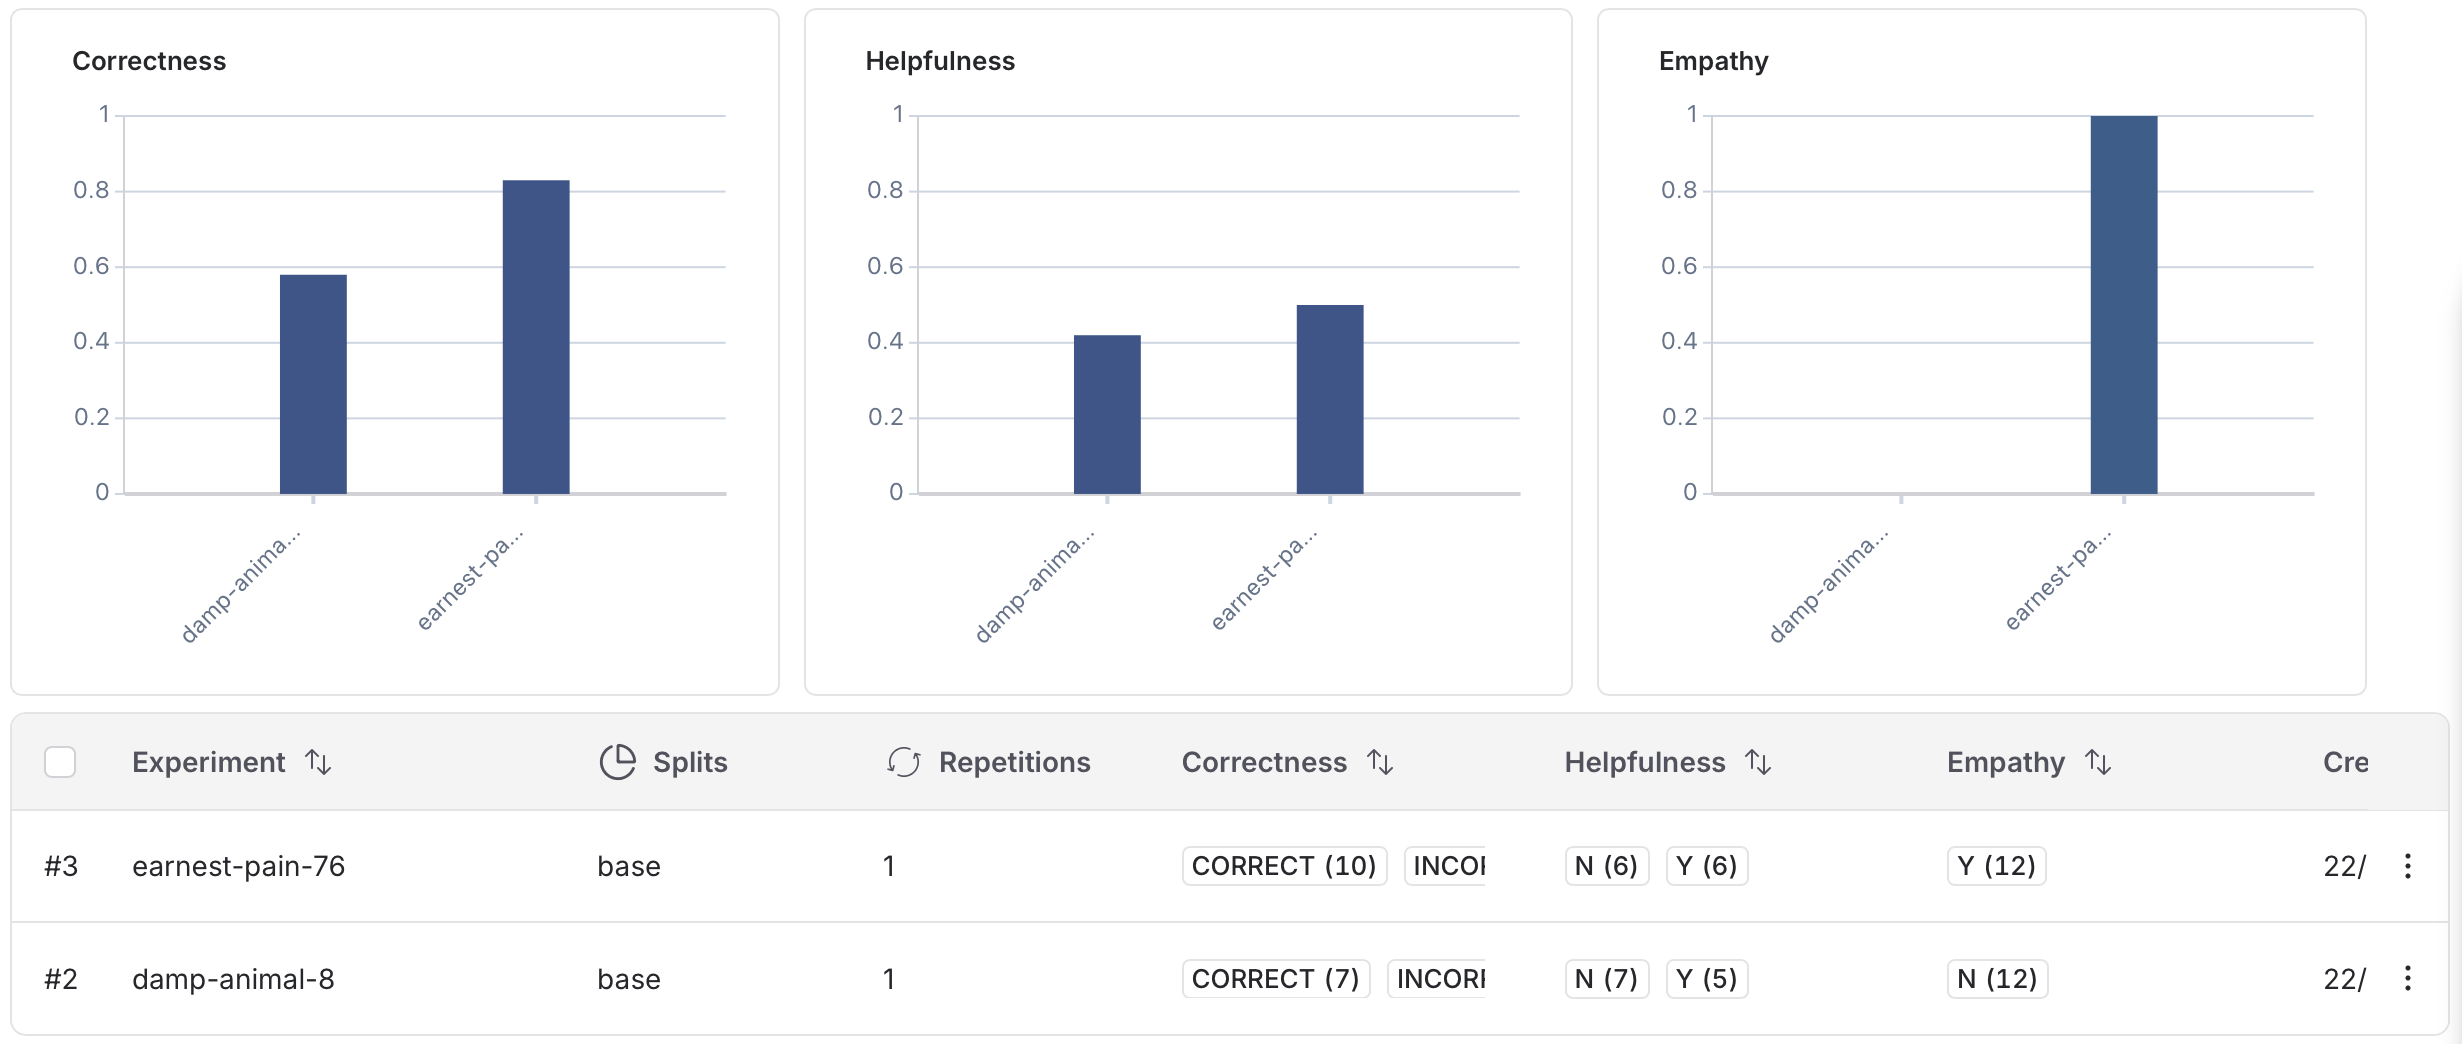

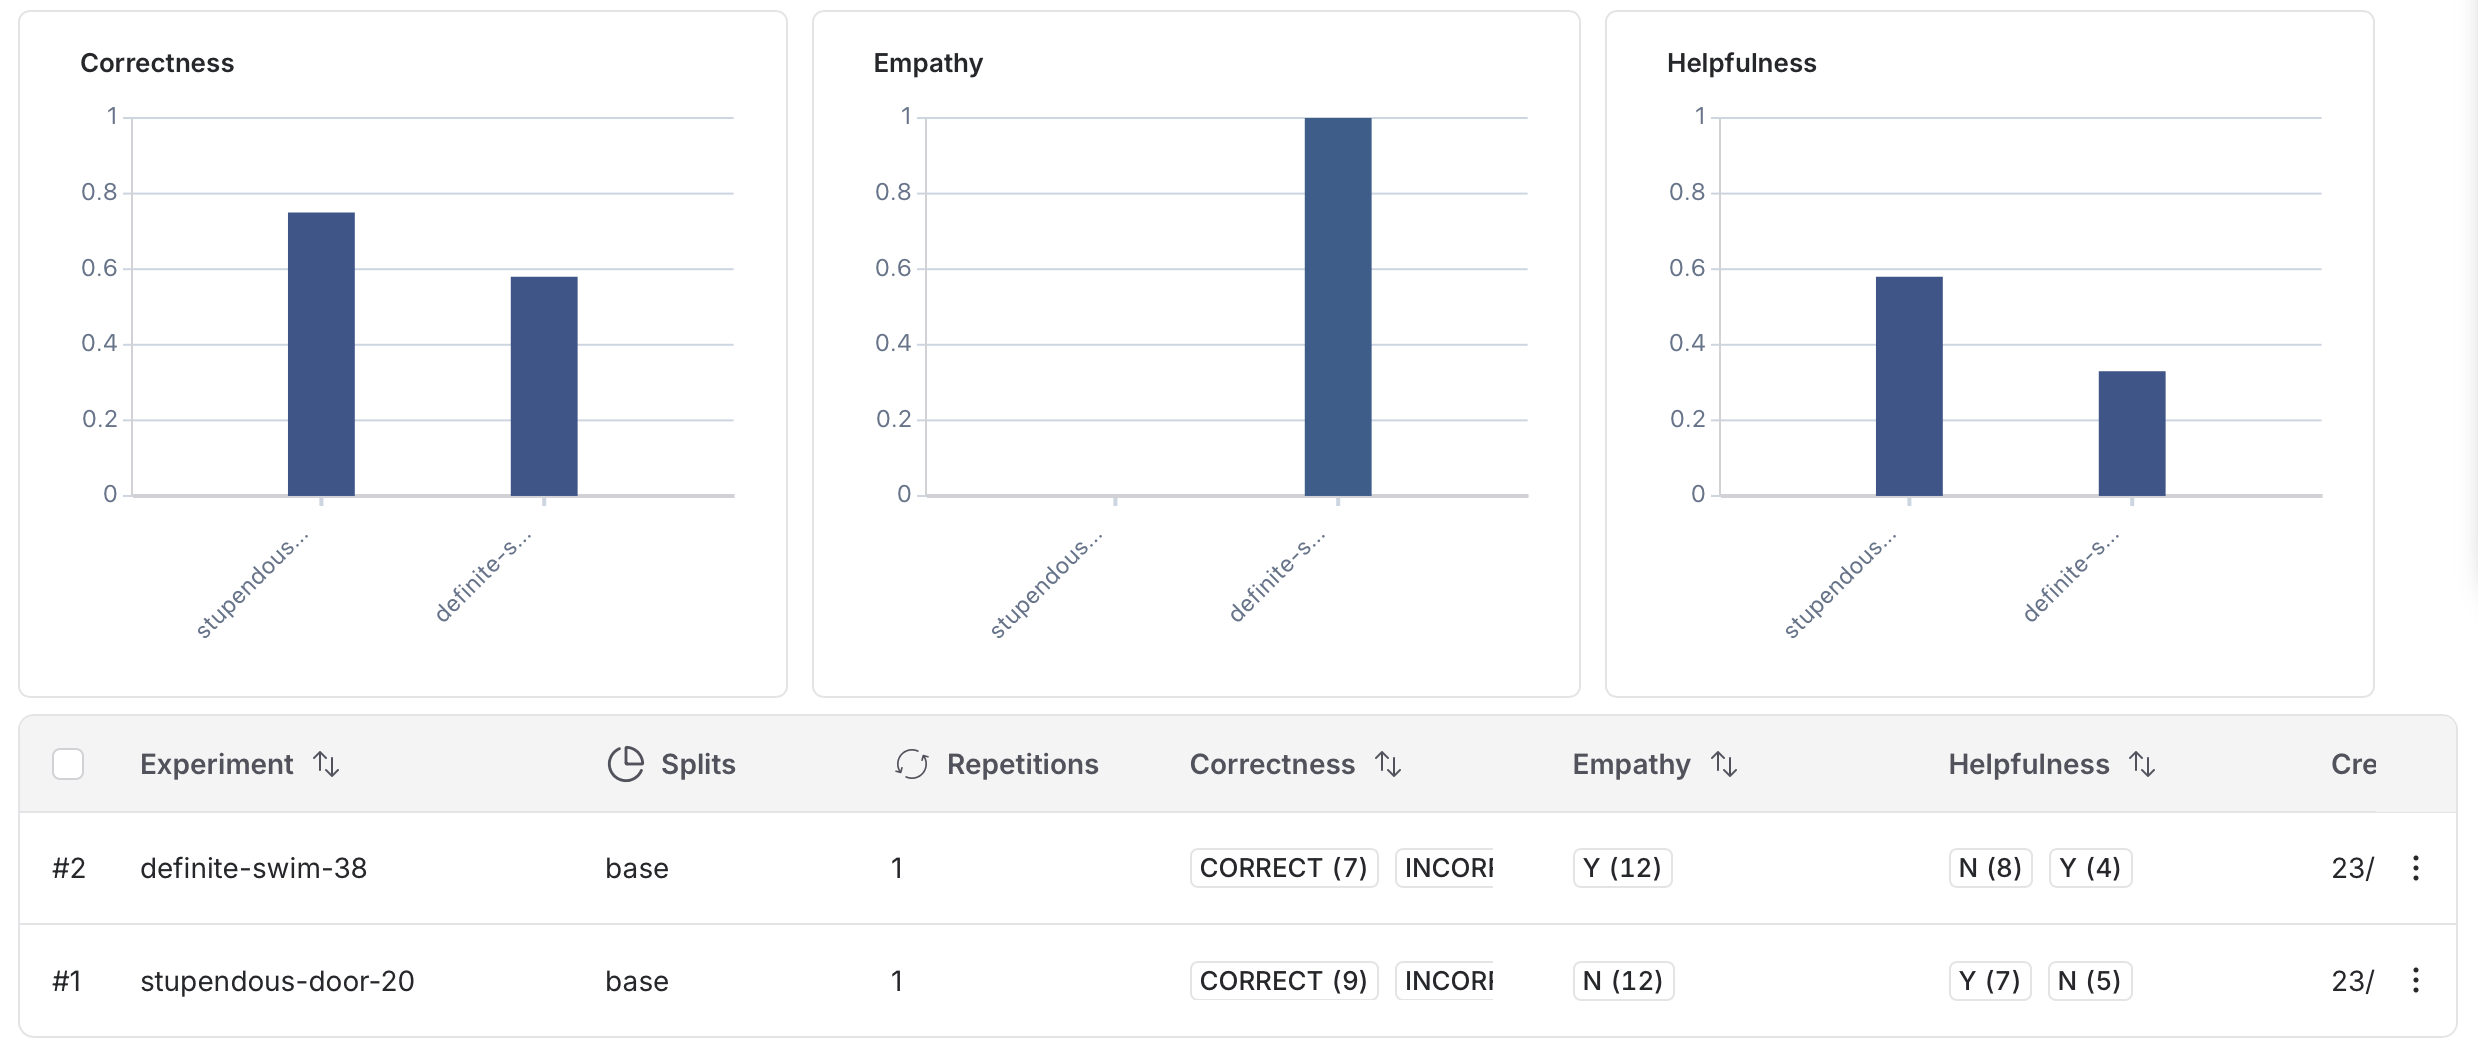

In [43]:
from IPython.display import Image, display
display(Image("sdg.png"))
display(Image("sdg2.png"))

Ran the notebook twice:

1. In terms of correctness and helpfulness, both chains are similar, despite having different chunk sizes
2. The empathetic RAG has perfect empathy while the base RAG does not exhibit any empathy